# Predicting Ground Water Levels with Kernel Regression

In [1]:
from __future__ import absolute_import, division, print_function

import os
import json
import math
import pyro
import torch
import pickle
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyro.distributions as dist
import matplotlib.animation as animation

from functools import partial
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC
from IPython.display import Video, HTML, Image, display
from helper import pairwise_distances, summary, visualize_posterior, plot_data, plot_2d_dist

pyro.set_rng_seed(0)

In [2]:
%matplotlib inline
logging.basicConfig(format="%(message)s", level=logging.INFO)

# Enable validation checks
pyro.enable_validation(True)

smoke_test = "CI" in os.environ
smoke_test = False

assert pyro.__version__.startswith("0.4.1")

In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [4]:
use_gp = False

if smoke_test:
    plot = True
    train = True
    save_samples = False
    
    num_samples = 1
    warmup_steps = 1
else:
    plot = True
    train = False
    save_samples = False
    
    num_samples = 100
    warmup_steps = 400

## Background

Our area of interest was a small area (125 km x 69 km) in North Western India in the arid state Rajasthan.  Rajasthan is a state with very little rainfall and thus depends heavily on groundwater for irrigation for agriculture to exist.  The groundwater exists in ancient, extinct aquifers that no longer have very large meaningful inflows, so most extraction will permanantly remove water that could be used in the future.

Therefore we posit that there could be certain farmers that are doing significantly more extraction than others, and we assume this pattern of usage can be inferred by the amount of water table decrease in the surrounding wells.

We use a rough hydrological model to inform our predictions, that is that the rate of water extract decreases rapidly as the distance from the well that's extracting.

**Figure 1:** Cone of depression created by extracting water from a well. The influence of that extraction on the water level at a given distance from the well decreases exponentially from the source of extraction.

<img src="includes/depression_cone.png" alt="drawing" width="600"/>

Our model assumes roughly that there would be an extracting well at each visible pixel.  Here are two different wells that motivated our analysis.  You can see in these false color images (used to emphasize vegitation) that some wells have singificantly more surrounding vegitation than others.  The well on the left exhibts significantly more extraction over time than the well on the right with fewer farm pixels. 

**Figure 2a/b :** Two different wells with varying amounts of surrounding vegitation. Note the regular shape of farmland edges that are exploited using the edge detection feature
![]() ![](/includes/Right_Well2.PNG)

<img src="includes/Left_well.png" alt="drawing" width="600"/> 
<img src="includes/Right_Well2.PNG" alt="drawing" width="600"/>

**Figure 3:** Time Series showing depth to well at two different highlighted wells

<img src="includes/well_depth_plot.png" alt="drawing" width="600"/>

### Dataset
The dataset is comprised of classifications of farmland pixels from  satellite imagery and point data of observation wells' depth to groundwater over time.  The satellite images were create in Google Earth Enigne `/earth-engine/` which is a cloud computing platform to allow researchers to access very large scale image datasets and perform operations quickly and efficiently.

We use Landsat 5 and draw seasonal observations over the period 1996 to 2010. To create our classifier we use 4 important bands Near Infrared (NIR), Shortwave Infrared (SWIR), Visible Red, and a vegitation index that is a combination of the previous bands (EVI).  We then create features and hand-crafted convolutions on top of these layers using the Canny edge detection algorithm and various kernels on both the edge detection layers and the underlying bands.  

**Figure 4:** Image of EVI band (left) and a layer of the same band (right) after using the Canny edge detection algorithm.
![](/includes/evi.PNG) ![](/includes/evi_edge.PNG) 

We then create a dataset of training and testing pixels by using a combination of the false color images and Google Earth's very high resolution proprietary dataset ($\approx1 \> m$) per pixel to determine if the features seen in our false color image were indeed anthropogenic vegitation.  

**Figure 5:** Real color high-resolution image from Google Earth Image, proprietary 2019.
![](/includes/GoogleEarth_realcolor.PNG)

We then use the above-mentioned features and the training and testing pixels (20% held out) to train a Random Forest classifier.  After some cross validation we report an overall testing accuracy of 91.61 with the following performance table:

|                | Farm Testing | Not Farm Testing | 
|----------------|--------------|------------------|
| **Farm Model**     | 209          | 20               | 
| **Not Farm Model** | 9            | 108              | 

We then use the random forest to classify our entire region of interest in all time steps. The end result of the classification of all pixels can be seen in the following video where wells are plotted as squares whose darkeness indicates the depth to the water table.  I.e. a deeper watertable is indicated by a darker pixel.

In [5]:
Video("includes/real-data-animation.mp4")

## Modeling the Water Level

### Generative Model
---
**Farm Factor**
\begin{align*}
    \ln(\delta) \sim \mathcal{N}(1.0, 0.5)
\end{align*}

**Distance Factors**
\begin{align*}
    \ln(\theta_w) \sim \mathcal{N}(0.0, 0.5) \\
    \ln(\theta_f) \sim \mathcal{N}(0.0, 0.5)
\end{align*}

**Variance**
\begin{align*}
    \sigma^2 \sim \text{Gam}(1.0, 1.0)
\end{align*}

**Seasonal Factors**
For season $s \in \mathcal{S}$
\begin{align*}
    \gamma_s \sim \mathcal{N}(0.0, 1.0)
\end{align*}

**Base Water Levels**

The base water levels are modeled as a simple AR(1) process.
The details of this are as follows

\begin{align*}
    \mu_0 \sim \mathcal{N}(\gamma_{s_0}, 1.0) \\
\end{align*}
For $t = 1 \dots T$, we specify
\begin{align*}
    \mu_{t} \sim \mathcal{N}(\mu_{t - 1} + \gamma_{s_t}, 1.0)
\end{align*}

**Likelihood**

For $t = 0 \dots T$, we specify
\begin{align*}
    \mathbf{y}_t \sim 
    \mathcal{N}(\mu_t - \delta \cdot K(X_{t,w}, X_{t,f})\ /\ \theta_f, 1.0)
\end{align*}

---

<img src="includes/hmm-model1.png" alt="drawing" width="600"/>

### Defining the Model

In [6]:
def model1(XW, YW, YF, WF_distances, n_seasons=4, seasons=None, gp=False):
    assert not torch._C._get_tracing_state()

    delta = pyro.sample("delta", dist.LogNormal(1.0, 0.5))

    if gp:
        theta_w = pyro.sample("theta_w", dist.LogNormal(0.0, 0.5))
    else:
        sigma = pyro.sample("sigma", dist.Gamma(1.0, 1.0))

    theta_f = pyro.sample("theta_f", dist.LogNormal(0.0, 0.5))

    sf = pyro.sample("sf", dist.Normal(torch.zeros(n_seasons), 1.0))
    if seasons is None:
        seasons = np.tile(np.arange(n_seasons), int(len(YW) / n_seasons + 1))
        seasons = seasons[:len(YW)]

    mu = 0
    for t in pyro.markov(range(len(YW))):
        if gp:
            sigma = torch.exp(-pairwise_distances(XW[t], XW[t]) / theta_w)

        mu = pyro.sample(
            "mu_{}".format(t), dist.Normal(mu + sf[seasons[t]], 1.0)
        )

        mean = mu - delta * torch.mm(
            torch.exp(-WF_distances[t] / theta_f), YF[t]
        )

        if gp:
            pyro.sample(
                "obs_{}".format(t),
                dist.MultivariateNormal(mean, sigma),
                obs=YW[t]
            )
        else:
            with pyro.plate("data_{}".format(t), len(YW[t])):
                pyro.sample(
                    "obs_{}".format(t), dist.Normal(mean, sigma), obs=YW[t]
                )

In [7]:
def predict1(
    XW, XF, YF, samples, n_seasons=4, seasons=None, gp=False, recon=False
):
    sigma = samples["sigma"]
    delta = samples["delta"]

    if gp:
        theta_w = samples["theta_w"]

    theta_f = samples["theta_f"]

    sf = samples["sf"]
    if seasons is None:
        seasons = np.tile(np.arange(n_seasons), int(len(YW) / n_seasons + 1))
        seasons = seasons[:len(YW)]

    mu = samples["mu"]

    samples = []
    for t in range(len(YF)):
        YF_ = YF[t].cpu().numpy()

        if gp:
            pdx = pairwise_distances(XW[t]).cpu().numpy()
        pdf = pairwise_distances(XW[t], XF[t]).cpu().numpy()

        samples_ = []
        for i in range(len(delta)):
            if gp:
                sg = np.exp(-pdx / theta_w[i])
            else:
                sg = sigma[i]

            mean = (
                mu[i, t]
                - delta[i] * np.matmul(np.exp(-pdf / theta_f[i]), YF_)
                + sf[i][seasons[t]]
            )
            if recon:
                samples_.append(mean)
            else:
                samples_.append(np.random.normal(mean, sg))

        samples_ = np.array(samples_)
        samples.append(samples_)

    return samples

## Sanity Check - Working with Sample Data

### Reading the Sample Data

In [8]:
data = pd.read_csv("data/test-data.csv", encoding="ISO-8859-1")

data_wells = data[data.type == "well"]
data_farms = data[data.type == "farm"]

XW, YW = [], []
for t in data_wells["timestep"].unique():
    data_ = data_wells[data_wells["timestep"] == t]

    XW.append(data_[["latitude", "longitude"]].values)
    YW.append(data_["observation"].values)

XW = XW[0]

XF = data_farms[["latitude", "longitude"]].values
YF = data_farms["observation"].values

In [9]:
if plot:
    try: 
        plot_data(XF, XW, YW, path="includes/sample-data-animation.mp4")
    except ValueError:
        print("The above command requires ffmpeg to be installed on the system")

Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x1000', '-pix_fmt', 'rgba', '-r', '1', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'includes/sample-data-animation.mp4']


<Figure size 432x288 with 0 Axes>

In [10]:
Video("includes/sample-data-animation.mp4")

In [11]:
XW = torch.tensor(XW)
YW = torch.tensor(YW)[..., None]

XF = torch.tensor(XF)
YF = torch.tensor(YF)[..., None]

In [12]:
timesteps = len(YW)

XW = XW.repeat(timesteps, 1, 1)

YF = YF.repeat(timesteps, 1, 1)
XF = XF.repeat(timesteps, 1, 1)

### Inference (Sample Data - Model 1)

In [13]:
pyro.set_rng_seed(1)

In [14]:
samples_file = "models/model1/test-samples.json"

In [15]:
try:
    with open(samples_file, "r") as f:
        samples = {k: np.array(v) for k, v in json.load(f).items()}
except:
    print("Failed to load samples file")

In [16]:
if train:
    WF_distances = [pairwise_distances(XW[i], XF[i]) for i in range(len(YW))]

    nuts_kernel = NUTS(
        partial(model1, n_seasons=4, WF_distances=WF_distances, gp=use_gp)
    )

    mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps)
    mcmc_run = mcmc.run(XW, YW, YF)

    samples = {
        k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()
    }

In [17]:
mu_samples = []
for k in list(samples.keys()):
    if "mu_" in k:
        mu_samples.append(samples[k][:, None])
        del samples[k]

samples["mu"] = np.concatenate(mu_samples, axis=1)

In [18]:
if save_samples:
    samples_ = {k: v.tolist() for k, v in samples.items()}
    with open(samples_file, "w") as f:
        json.dump(samples_, f)

## Working with Real Data 

### Reading the Real Data

In [19]:
with open("data/real-data.pkl", "rb") as f:
    XF_r = [np.array(x) for x in pickle.load(f)]
    YF_r = [np.array(x) for x in pickle.load(f)]

    XW_r = [np.array(x) for x in pickle.load(f)]
    YW_r = [np.array(x) for x in pickle.load(f)]

    XS_r = pickle.load(f)

In [20]:
if plot:
    plt.clf()
    fig = plt.figure(figsize=(10, 10), dpi=100)

    plt.ion()

    scat_f = plt.scatter(
        XF_r[0][:, 0], XF_r[0][:, 1], marker="s", s=7, color="lightgreen"
    )

    scat_w = plt.scatter(
        XW_r[0][:, 0],
        XW_r[0][:, 1], marker="s", s=20, c=[(0, 0, 0, 1)] * len(XW_r[0])
    )
    label = plt.text(0, 0, '', fontsize=12)

    def update_plot(i, scat_w, scat_f):
        scat_w.set_offsets(XW_r[i])
        scat_w.set_array(np.array([min(1 - abs(x[0]) / 50, 1) for x in YW_r[i]]))

        scat_f.set_offsets(XF_r[i])
        return scat_w, scat_f

    anim = animation.FuncAnimation(
        fig,
        update_plot,
        frames=range(len(XW_r)),
        fargs=(scat_w, scat_f),
        interval=1000
    )

    plt.gray()
    
    anim.save("includes/real-data-animation.mp4", fps=1)

    plt.close()
    
# if plot:
#     try: 
#         plot_data(XF_r, XW_r, YW_r, )
#     except ValueError:
#         print("The above command requires ffmpeg to be installed on the system")

Video("includes/real-data-animation.mp4")

Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x1000', '-pix_fmt', 'rgba', '-r', '1', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'includes/real-data-animation.mp4']


<Figure size 432x288 with 0 Axes>

In [21]:
XF_r = [torch.tensor(x) for x in XF_r]
YF_r = [torch.tensor(x) for x in YF_r]

XW_r = [torch.tensor(x) for x in XW_r]
YW_r = [torch.tensor(x) for x in YW_r]

XS_r = torch.tensor(XS_r) - 1

In [22]:
Xs = torch.cat(XW_r + XF_r)

In [23]:
x_mean = Xs.mean(0)
x_std = Xs.std(0)

In [24]:
XW_r = [(x - x_mean) / x_std for x in XW_r]
XF_r = [(x - x_mean) / x_std for x in XF_r]

### Inference (Real Data - Model 1)

In [25]:
pyro.set_rng_seed(1)

In [26]:
samples_file = "models/model1/real-samples.json"

In [27]:
try:
    with open(samples_file, "r") as f:
        samples = {k: np.array(v) for k, v in json.load(f).items()}
except:
    print("Failed to load samples file")

In [28]:
if train:
    WF_distances = [
        pairwise_distances(XW_r[i], XF_r[i]) for i in range(len(YW_r))
    ]

    nuts_kernel = NUTS(
        partial(
            model1,
            n_seasons=3,
            seasons=XS_r,
            WF_distances=WF_distances,
            gp=use_gp
        )
    )

    mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps)
    mcmc_run = mcmc.run(XW_r, YW_r, YF_r)

    samples = {
        k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()
    }

In [29]:
mu_samples = []
for k in list(samples.keys()):
    if "mu_" in k:
        mu_samples.append(samples[k][:, None])
        del samples[k]

samples["mu"] = np.concatenate(mu_samples, axis=1)

In [30]:
if save_samples:
    samples_ = {k: v.tolist() for k, v in samples.items()}
    with open(samples_file, "w") as f:
        json.dump(samples_, f)

### Posterior Visualizations (Real Data - Model 1)

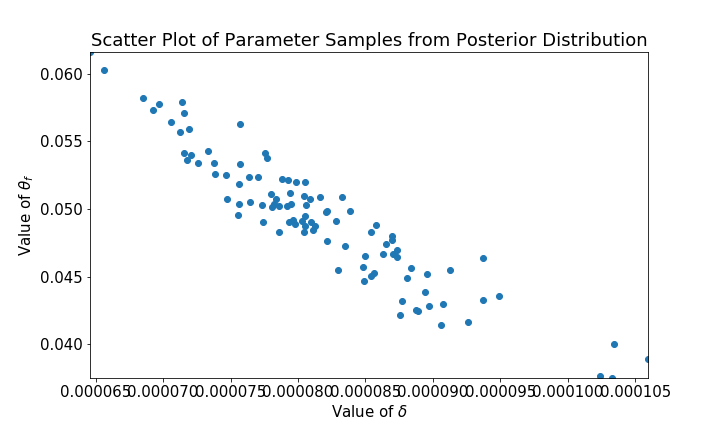

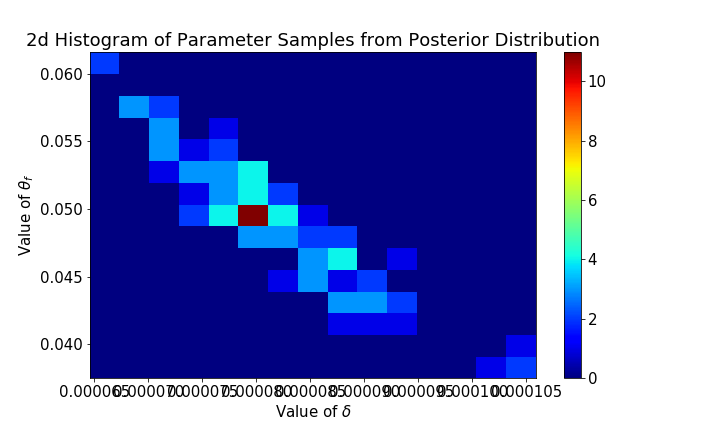

In [31]:
# 2d scatterplot (maximum ascent would be where theta= delta *distance )
if plot:
    plot_2d_dist("delta", "theta_f", samples, "1")

display(
    Image("includes/model1/scatter_delta_theta_f.png"),
    Image("includes/model1/hist_delta_theta_f.png")
)

$\theta_f$ implicitly determines the effective distance. At 23 latitutude, one degree of latitude is 110,758 m and one degree of longitude is 101,751 m.  Hence if we have a well that is $\sqrt{(.001)^2 + (.001)^2}$ or $\sqrt{110^2+101^2}\approx 150 m$ away then 
$\theta_f$ of 0.2 will give the importance of a single pixel at that distance as $\delta \times e^{(-.001/0.2)}\times y_f$.  If we assume we have on the order of 400 classified pixels within that distance, we can calculate the total effect of the farms on a given well as $\delta \times e^{(0.001/2)}\times y_f\times 500$.   

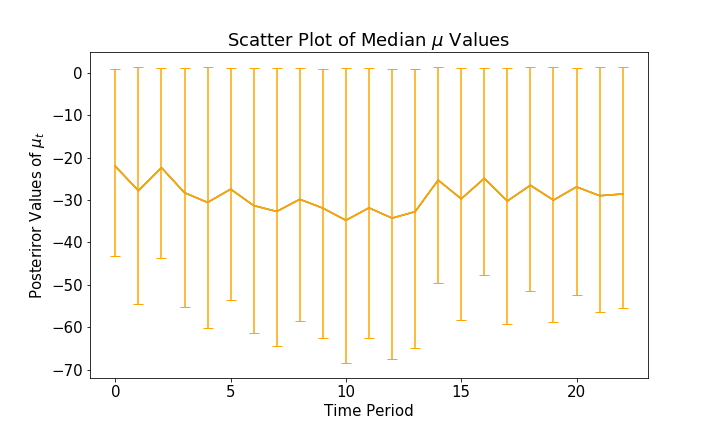

In [32]:
if plot:
    # Grab quantiles and medians and plot them
    mu_post_list_med = np.median(samples["mu"], 0)
    mpl_quant = np.quantile(samples["mu"], q=(0.025, 0.975), axis=0)

    fig, ax = plt.subplots(figsize=(10, 6),)
    ax.plot(mu_post_list_med)
    ax.set(
        ylabel=r"Posteriror Values of $\mu_t$",
        xlabel=r"Time Period",
        title=r"Scatter Plot of Median $\mu$ Values",
    )

    plotline, caplines, barlinecols = plt.errorbar(
        list(range(len(mu_post_list_med))),
        mu_post_list_med,
        yerr=mpl_quant[1],
        lolims=True,
        label="uplims=True",
        color="orange",
    )
    caplines[0].set_marker("_")
    caplines[0].set_markersize(10)

    plotline2, caplines2, barlinecols2 = plt.errorbar(
        list(range(len(mu_post_list_med))),
        mu_post_list_med,
        yerr=mpl_quant[0],
        uplims=True,
        label="uplims=True",
        color="orange",
    )
    caplines2[0].set_marker("_")
    caplines2[0].set_markersize(10)

    plt.savefig("includes/model1/mu.png")
    plt.close()

Image("includes/model1/mu.png")

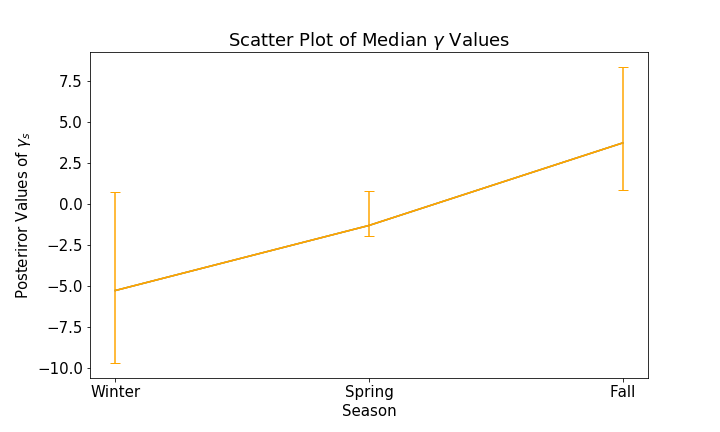

In [33]:
if plot:
    # Grab quantiles and medians and plot them
    sf_post_list_med = np.median(samples["sf"], 0)
    mpl_quant = np.quantile(samples["sf"], q=(0.025, 0.975), axis=0)

    fig, ax = plt.subplots(figsize=(10, 6),)
    ax.plot(sf_post_list_med)
    ax.set(
        ylabel=r"Posteriror Values of $\gamma_s$",
        xlabel=r"Season",
        title=r"Scatter Plot of Median $\gamma$ Values",
    )
    plt.xticks(np.arange(3), ["Winter", "Spring", "Fall"])

    plotline, caplines, barlinecols = plt.errorbar(
        list(range(len(sf_post_list_med))),
        sf_post_list_med,
        yerr=mpl_quant[1],
        lolims=True,
        label="uplims=True",
        color="orange",
    )
    caplines[0].set_marker("_")
    caplines[0].set_markersize(10)

    plotline2, caplines2, barlinecols2 = plt.errorbar(
        list(range(len(sf_post_list_med))),
        sf_post_list_med,
        yerr=mpl_quant[0],
        uplims=True,
        label="uplims=True",
        color="orange",
    )
    caplines2[0].set_marker("_")
    caplines2[0].set_markersize(10)

    plt.savefig("includes/model1/sf.png")
    plt.close()

Image("includes/model1/sf.png")

### Model Criticism

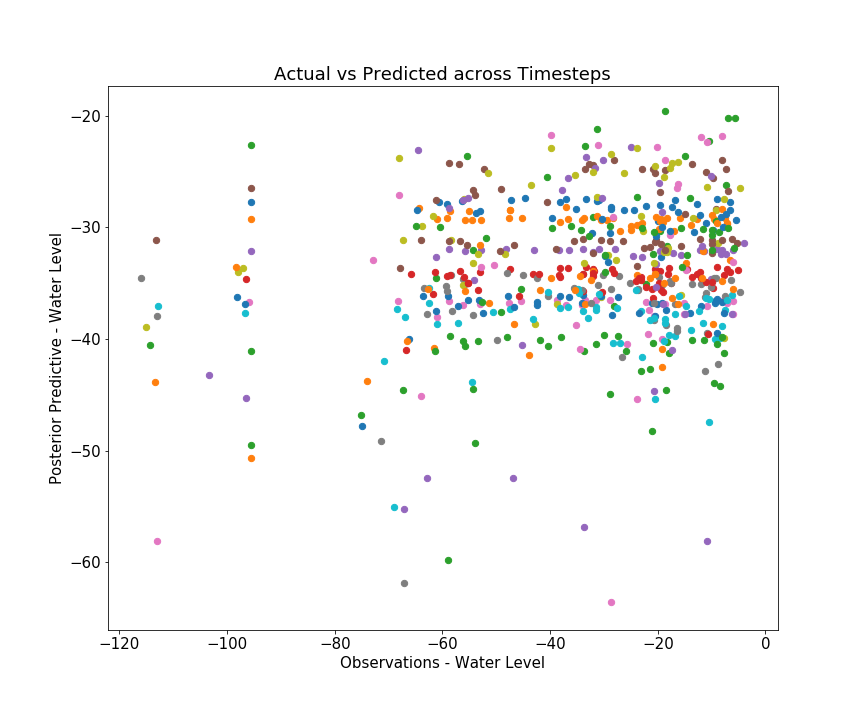

In [34]:
if plot:
    fig = plt.figure(figsize=(12, 10))
    
    preds = predict1(XW_r, XF_r, YF_r, samples, n_seasons=3, seasons=XS_r, recon=True)    
    preds = [x.mean(0) for x in preds]
    
    Y = [x.cpu().numpy() for x in YW_r]
    
    for p, y in zip(preds, Y):
        plt.scatter(y, p, s=40)
        
    plt.ylabel("Posterior Predictive - Water Level")
    plt.xlabel("Observations - Water Level")
    plt.title("Actual vs Predicted across Timesteps")
    
    plt.savefig("includes/model1/predicted_actual.png")
    
    plt.close()

Image("includes/model1/predicted_actual.png")

### Generative Model
---
**Farm Factor**
\begin{align*}
    \ln(\delta_c) \sim \mathcal{N}(1.0, 0.5)
    \ln(\delta_f) \sim \mathcal{N}(1.0, 0.5)
\end{align*}

**Distance Factor**
\begin{align*}
    \ln(\theta_f) \sim \mathcal{N}(1.0, 0.5)
\end{align*}

**Variance**
\begin{align*}
    \sigma^2 \sim \text{Gam}(1.0, 1.0)
\end{align*}

**Seasonal Factors**

For all seasons $s \in \mathcal{S}$, we define
\begin{align*}
    \gamma_s \sim \mathcal{N}(0.0, 1.0)
\end{align*}

**Likelihood**

The water level for each well is modeled as an AR(1) process which is dependent on the previous timestep. The details are as given below

For $t = 1 \dots T$, we specify
\begin{align*}
    \mathbf{y_t} - \mathbf{y_{t - 1}} \sim
    \mathcal{N}\left(
      \gamma_{s_t}
      + \delta_c\; \text{exp} \odot \frac{-K(X_{t,w}, X_{t,f})}{\theta_f}
      + \delta_p\; \text{exp} \odot \frac{-K(X_{t-1,w}, X_{t-1,f})}{\theta_f}
    , 1.0\right) \\
\end{align*}

---

<img src="includes/hmm-model2.png" alt="drawing" width="600"/>

### Defining the Model

In [35]:
def model2(XW, YW, YF, WF_distances, n_seasons=3, seasons=None):
    assert not torch._C._get_tracing_state()

    delta_c = pyro.sample("delta_c", dist.LogNormal(1.0, 0.5))
    delta_p = pyro.sample("delta_p", dist.LogNormal(1.0, 0.5))

    sigma = pyro.sample("sigma", dist.Gamma(1.0, 1.0))
    theta_f = pyro.sample("theta_f", dist.LogNormal(1.0, 0.5))

    sf = pyro.sample("sf", dist.Normal(torch.zeros(n_seasons), 1.0))
    if seasons is None:
        seasons = np.tile(np.arange(n_seasons), int(len(YW) / n_seasons + 1))
        seasons = seasons[:len(YW)]

    y = YW[0]
    ff = torch.mm(torch.exp(-WF_distances[0] / theta_f), YF[0])

    for t in pyro.markov(range(1, len(YW))):
        with pyro.plate("data_{}".format(t), len(YW[t])):
            mean = y - delta_p * ff + sf[seasons[t]]
            ff = torch.mm(torch.exp(-WF_distances[t] / theta_f), YF[t])

            mean -= delta_c * ff

            y = pyro.sample(
                "obs_{}".format(t), dist.Normal(mean, sigma), obs=YW[t]
            )

In [36]:
def predict2(XW, XF, YF, samples, n_seasons=3, seasons=None, recon=False):
    sigma = samples["sigma"]
    delta_c = samples["delta_c"]
    delta_p = samples["delta_p"]

    theta_f = samples["theta_f"]

    sf = samples["sf"]
    if seasons is None:
        seasons = np.tile(np.arange(n_seasons), int(len(YW) / n_seasons + 1))
        seasons = seasons[:len(YW)]

    YF = [x.cpu().numpy() for x in YF]

    samples = []
    samples_ = [0] * len(sigma)
    for t in range(1, len(YF)):
        pdf_c = pairwise_distances(XW[t], XF[t]).cpu().numpy()
        pdf_p = pairwise_distances(XW[t - 1], XF[t - 1]).cpu().numpy()

        for i in range(len(sigma)):
            sg = sigma[i]
            mean = (
                samples_[i]
                - delta_c[i] * np.matmul(np.exp(-pdf_c / theta_f[i]), YF[t])
                - delta_p[i] * np.matmul(np.exp(-pdf_p / theta_f[i]), YF[t-1])
                + sf[i][seasons[t]]
            )

            if recon:
                samples_[i] = mean
            else:
                samples_[i] = np.random.normal(mean, sg)

        samples_ = np.array(samples_)
        samples.append(samples_)

    return samples

### Preparing the Real Data

In [37]:
intersection = XW_r[0]

for arr in XW_r[1:]:
    indices = torch.zeros(len(arr), dtype=torch.bool)
    for elem in intersection:
        indices = indices | (torch.abs(arr - elem).sum(1) < 1e-8)
    intersection = arr[indices]

for i in range(len(XW_r)):
    indices = torch.zeros(len(XW_r[i]), dtype=torch.bool)
    for elem in intersection:
        indices = indices | (torch.abs(XW_r[i] - elem).sum(1) < 1e-8)

    XW_r[i] = XW_r[i][indices]
    YW_r[i] = YW_r[i][indices]

### Inference (Real Data - Model 2)

In [38]:
pyro.set_rng_seed(1)

In [39]:
samples_file = "models/model2/real-samples.json"

In [40]:
try:
    with open(samples_file, "r") as f:
        samples = {k: np.array(v) for k, v in json.load(f).items()}
except:
    print("Failed to load samples file")

In [41]:
if train:
    WF_distances = [
        pairwise_distances(XW_r[i], XF_r[i]) for i in range(len(YW_r))
    ]

    nuts_kernel = NUTS(
        partial(model2, seasons=XS_r, WF_distances=WF_distances)
        )

    mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps)
    mcmc_run = mcmc.run(XW_r, YW_r, YF_r)

    samples = {
        k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()
    }

if save_samples:
    samples_ = {k: v.tolist() for k, v in samples.items()}
    with open(samples_file, "w") as f:
        json.dump(samples_, f)

### Posterior Visualizations (Real Data - Model 2)

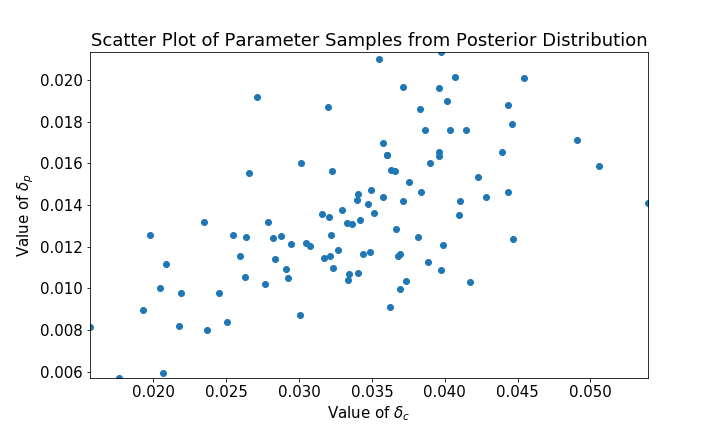

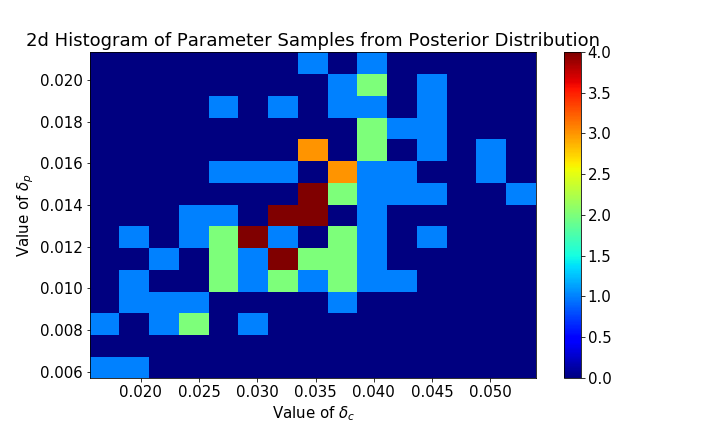

In [42]:
if plot:
    plot_2d_dist("delta_c", "delta_p", samples, "1")
    
display(
    Image("includes/model1/scatter_delta_c_delta_p.png"),
    Image("includes/model1/hist_delta_c_delta_p.png")
)

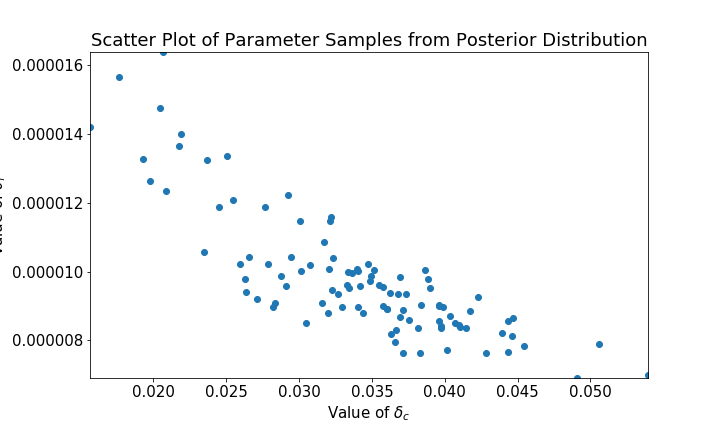

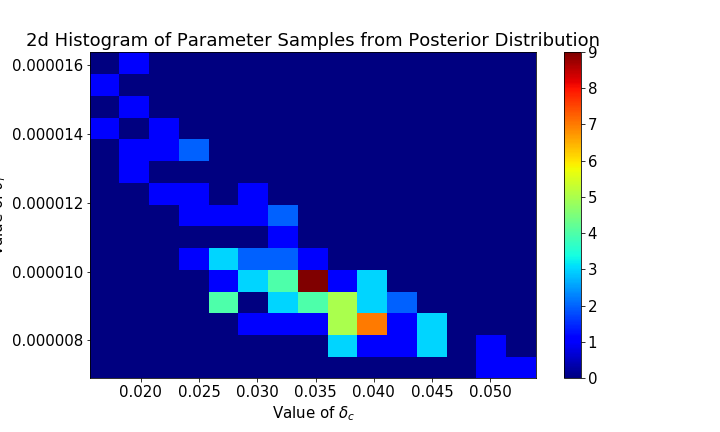

In [43]:
if plot:
    plot_2d_dist("delta_c", "theta_f", samples, "1")
    
display(
    Image("includes/model1/scatter_delta_c_theta_f.png"),
    Image("includes/model1/hist_delta_c_theta_f.png")
)

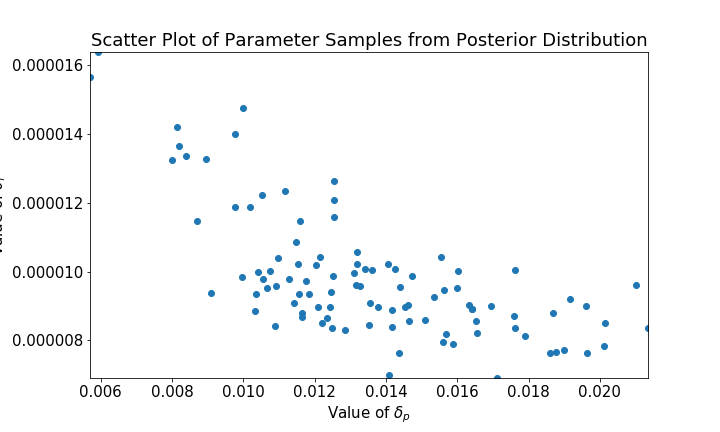

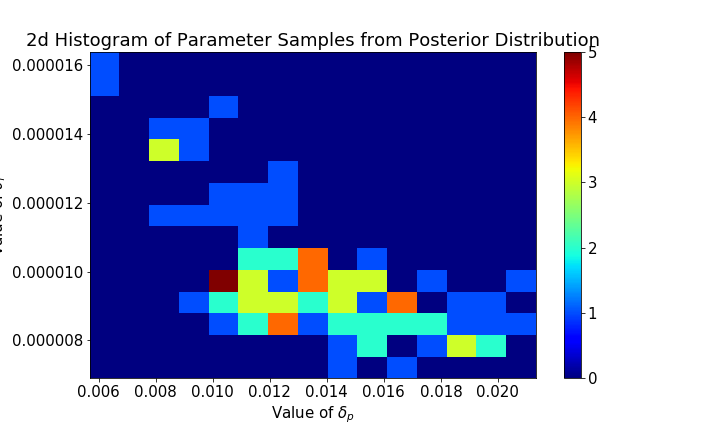

In [44]:
if plot:
    plot_2d_dist("delta_p", "theta_f", samples, "1")
    
display(
    Image("includes/model1/scatter_delta_p_theta_f.png"),
    Image("includes/model1/hist_delta_p_theta_f.png")
)

$\theta_f$ implicitly determines the effective distance. At 23 latitutude, one degree of latitude is 110,758 m and one degree of longitude is 101,751 m.  Hence if we have a well that is $\sqrt{(.001)^2 + (.001)^2}$ or $\sqrt{110^2+101^2}\approx 150 m$ away then 
$\theta_f$ of 0.2 will give the importance of a single pixel at that distance as $\delta \times e^{(-.001/0.2)}\times y_f$.  If we assume we have on the order of 400 classified pixels within that distance, we can calculate the total effect of the farms on a given well as $\delta \times e^{(0.001/2)}\times y_f\times 500$.   

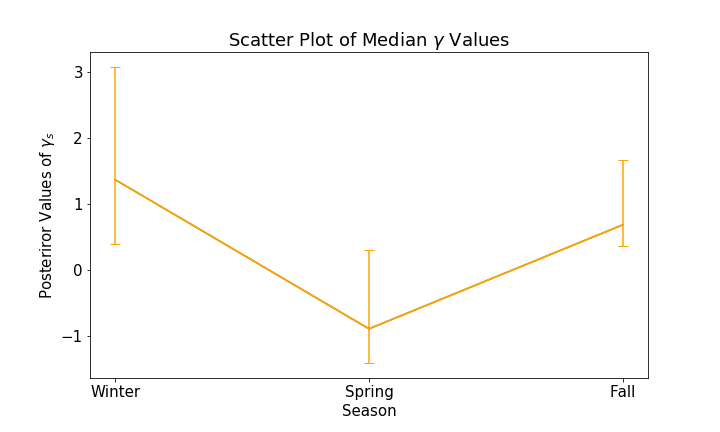

In [45]:
if plot:
    # Grab quantiles and medians and plot them
    sf_post_list_med = np.median(samples["sf"], 0)
    mpl_quant = np.quantile(samples["sf"], q=(0.025, 0.975), axis=0)

    fig, ax = plt.subplots(figsize=(10, 6),)
    ax.plot(sf_post_list_med)
    ax.set(
        ylabel=r"Posteriror Values of $\gamma_s$",
        xlabel=r"Season",
        title=r"Scatter Plot of Median $\gamma$ Values",
    )
    plt.xticks(np.arange(3), ["Winter", "Spring", "Fall"])

    plotline, caplines, barlinecols = plt.errorbar(
        list(range(len(sf_post_list_med))),
        sf_post_list_med,
        yerr=mpl_quant[1],
        lolims=True,
        label="uplims=True",
        color="orange",
    )
    caplines[0].set_marker("_")
    caplines[0].set_markersize(10)

    plotline2, caplines2, barlinecols2 = plt.errorbar(
        list(range(len(sf_post_list_med))),
        sf_post_list_med,
        yerr=mpl_quant[0],
        uplims=True,
        label="uplims=True",
        color="orange",
    )
    caplines2[0].set_marker("_")
    caplines2[0].set_markersize(10)

    plt.savefig("includes/model1/sf.png")
    plt.close()

Image("includes/model1/sf.png")

### Model Criticism

In [ ]:
preds = predict2(
    XW_r, XF_r, YF_r, samples, n_seasons=3, seasons=XS_r, recon=True
)

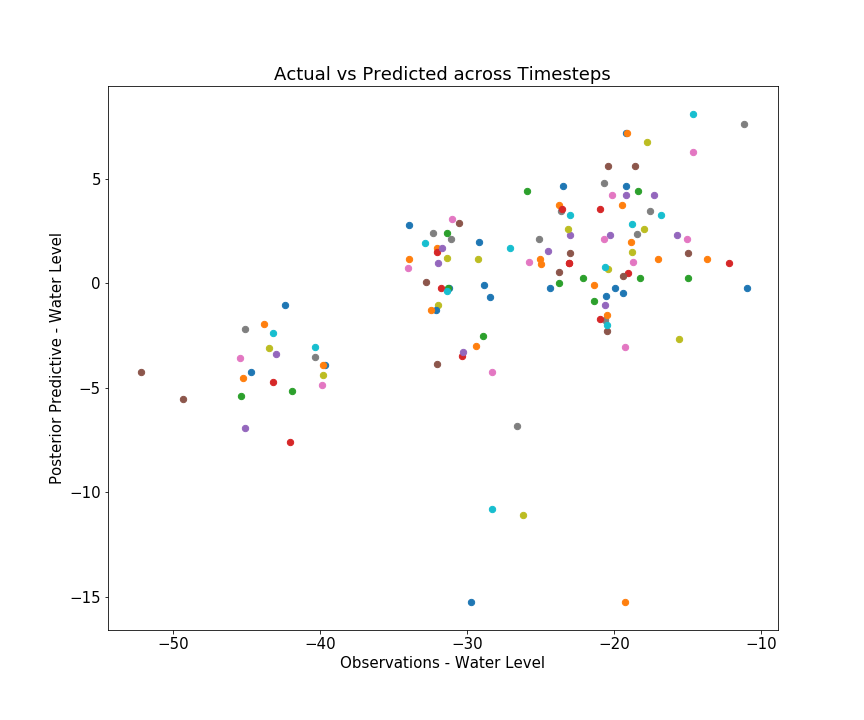

In [46]:
if plot:
    fig = plt.figure(figsize=(12, 10))
    
    preds = predict2(
        XW_r, XF_r, YF_r, samples, n_seasons=3, seasons=XS_r, recon=True
    )
    preds = [x.mean(0) for x in preds]
    
    Y = [x.cpu().numpy() for x in YW_r]
    
    for p, y in zip(preds, Y):
        plt.scatter(y, p, s=40)
        
    plt.ylabel("Posterior Predictive - Water Level")
    plt.xlabel("Observations - Water Level")
    plt.title("Actual vs Predicted across Timesteps")
    
    plt.savefig("includes/model1/predicted_actual.png")
    
    plt.close()
    
Image("includes/model1/predicted_actual.png")